In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

# Load Model Weights (may take a few minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = stable.tokenizer

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

# Pipeline Wrapper

In [4]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [5]:
prompt = "an elephant with a crown"
seeds = [21]

In [6]:
token_indices = get_indices_to_alter(stable, prompt)

{1: 'an', 2: 'elephant', 3: 'with', 4: 'a', 5: 'crown'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['elephant', 'crown']


## Stable Diffusion

  0%|          | 0/51 [00:00<?, ?it/s]

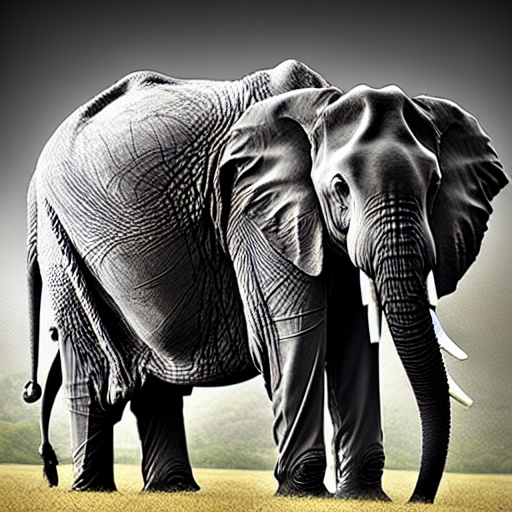

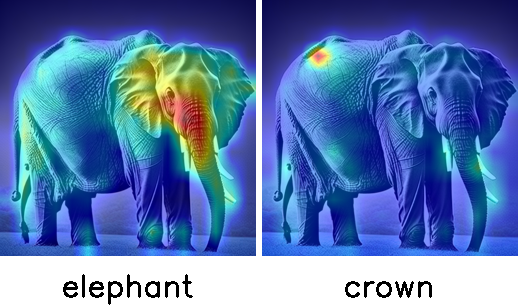

In [7]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=True,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

## Attend-and-Excite

  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8060
Iteration 1 | Loss: 0.0266
Iteration 2 | Loss: 0.0267
Iteration 3 | Loss: 0.0182
Iteration 4 | Loss: 0.0101
Iteration 5 | Loss: 0.0051
Iteration 6 | Loss: 0.0079
Iteration 7 | Loss: 0.0025
Iteration 8 | Loss: 0.0104
Iteration 9 | Loss: 0.0025
Iteration 10 | Loss: 0.0062
Iteration 11 | Loss: 0.0034
Iteration 12 | Loss: 0.0088
Iteration 13 | Loss: 0.0115
Iteration 14 | Loss: 0.0209
Iteration 15 | Loss: 0.0275
Iteration 16 | Loss: 0.0293
Iteration 17 | Loss: 0.0292
Iteration 18 | Loss: 0.0299
Iteration 19 | Loss: 0.0335
Iteration 20 | Loss: 0.0498
Iteration 21 | Loss: 0.0466
Iteration 22 | Loss: 0.0609
Iteration 23 | Loss: 0.0548
Iteration 24 | Loss: 0.0620


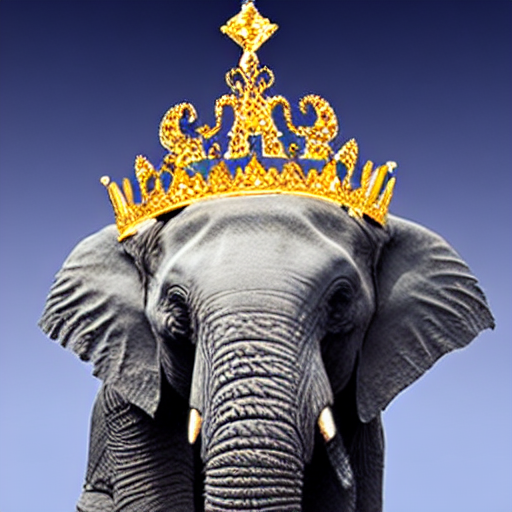

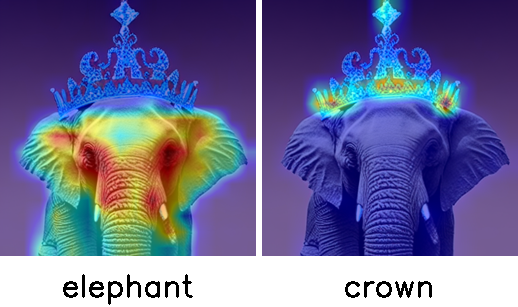

In [8]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)